# Notebook - Data Engineering
This notebook's function is replaced by training pipeline's src - data_engineering.py

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import warnings
import torch
warnings.filterwarnings("ignore")

### Import datasets

In [2]:
# import data
import_feature_path = "../raw_dataset/" # specify the input data 
# Import features
fuel_load_cwdc = np.load(file = import_feature_path + "fuel_load_cwdc.npy")
fuel_load_deadcrootc = np.load(file = import_feature_path + "fuel_load_deadcrootc.npy")
fuel_wetness = np.load(file = import_feature_path + "fuel_wetness.npy")
fuel_temperature = np.load(file = import_feature_path + "fuel_temperature.npy")
climate_wind = np.load(file = import_feature_path + "climate_wind.npy")
climate_tbot = np.load(file = import_feature_path + "climate_tbot.npy")
climate_rh2m = np.load(file = import_feature_path + "climate_rh2m.npy")
climate_rain = np.load(file = import_feature_path + "climate_rain.npy")
tree_coverage = np.load(file = import_feature_path + "tree_coverage.npy")
human_density = np.load(file = import_feature_path + "human_density.npy")
light_frequency = np.load(file = import_feature_path + "light_frequency.npy")
# import output
burned_area = np.load(file = import_feature_path + "burned_area.npy")
percentage_burned_area = np.load(file = import_feature_path + "percent_burned_area.npy")
grid_area = np.load(file = import_feature_path + "grid_area.npy")

### Compute valid grids

In [3]:
valid_grid = []
for i in range(96):
    for j in range(143):
        if np.sum(percentage_burned_area[:,i,j]) > 0:
            valid_grid.append([i,j])

### Generate dataset

In [4]:
year = 10 # latest 10 yrs
year_indic = 1800 - year * 12

In [5]:
conv_tool = torch.nn.Conv2d(1,1,(2,2), stride = (1,1), bias = False)
conv_tool.weight.data = torch.Tensor([[[[1,1],[1,1]]]])
pool_tool = torch.nn.MaxPool2d((2,2))

In [6]:
# Create a Dataframe
data = pd.DataFrame()

# Iterate to get the data
for i in tqdm(range(len(valid_grid)), desc='Processing'):
    index_value = valid_grid[i]
    # dataframes
    temp_df = pd.DataFrame()
    
    # === Basic Features
    temp_df["fuel_load_cwdc"] = fuel_load_cwdc[:,index_value[0],index_value[1]].tolist()
    temp_df["fuel_load_deadcrootc"] = fuel_load_deadcrootc[:,index_value[0],index_value[1]].tolist()
    temp_df["fuel_wetness"] = fuel_wetness[:,index_value[0],index_value[1]].tolist()
    temp_df["fuel_temperature"] = fuel_temperature[:,index_value[0],index_value[1]].tolist()
    temp_df["climate_wind"] = climate_wind[:,index_value[0],index_value[1]].tolist()
    temp_df["climate_tbot"] = climate_tbot[:,index_value[0],index_value[1]].tolist()
    temp_df["climate_rh2m"] = climate_rh2m[:,index_value[0],index_value[1]].tolist()
    temp_df["climate_rain"] = climate_rain[:,index_value[0],index_value[1]].tolist()
    temp_df["human_density"] = human_density[:,index_value[0],index_value[1]].tolist()
    temp_df["light_frequency"] = light_frequency[:,index_value[0],index_value[1]].tolist()
    # temp_df["tree_coverage"] = tree_coverage[:,10,index_value[0],index_value[1]].tolist()
    
    # === Label
    temp_df["burned_area"] = burned_area[:,index_value[0],index_value[1]].tolist()
    
    # === Additional Features
    temp_df["burned_area_mom"] = temp_df["burned_area"].shift()
    temp_df["burned_area_yoy"] = temp_df["burned_area"].shift(12)
    temp_df["month"] = [12,1,2,3,4,5,6,7,8,9,10,11] * 150
    temp_df["sequence"] = [i for i in range(1800)]
    temp_df["lat"] = index_value[0]
    temp_df["lon"] = index_value[1]
    
    
    # === Convolutional on Features of "burned_area_mom" & "burned_area_yoy"
    temp_join_list = []
    conv_burned_area = burned_area[:,(index_value[0]-1):(index_value[0]+2),(index_value[1]-1):(index_value[1]+2)]
    # judge the shape
    if conv_burned_area.shape[1] == 3 and conv_burned_area.shape[2] == 3:
        for i in range(burned_area.shape[0]):
            value_temp = torch.Tensor([conv_burned_area[i]])
            value_temp = conv_tool(value_temp)
            value_temp = pool_tool(value_temp)
            value_temp = value_temp.detach().numpy()[0][0][0]
            temp_join_list.append(value_temp)
    else:
        for i in range(burned_area.shape[0]):
            temp_join_list.append(None)
    
            
    # load convolution values to list
    temp_df["burned_area_conv"] = temp_join_list
    temp_df["burned_area_mom_conv"] = temp_df["burned_area_conv"].shift()
    temp_df["burned_area_yoy_conv"] = temp_df["burned_area_conv"].shift(12)
    del temp_df["burned_area_conv"]

    # === only leave useful sequences
    temp_df = temp_df.loc[temp_df["sequence"] >= year_indic]
    
    # === trim out zeros for burned areas
    temp_df["burned_area"] = temp_df["burned_area"].apply(lambda x: None if x == 0 else x)
    temp_df = temp_df.dropna(axis = 0, subset=["burned_area","burned_area_mom","burned_area_yoy","burned_area_mom_conv","burned_area_yoy_conv"])
    
    # === concat to data
    data = pd.concat([data,temp_df])

Processing: 100%|██████████| 3096/3096 [05:44<00:00,  8.98it/s]


### Step A: process burned_area

In [7]:
subset = data.copy()
print(len(subset))
# compute the log of burned_area
subset['burned_area'] = subset['burned_area'].apply(lambda x: np.log(x))
subset['burned_area_mom'] = subset['burned_area_mom'].apply(lambda x: np.log(x))
subset['burned_area_yoy'] = subset['burned_area_yoy'].apply(lambda x: np.log(x))
subset['burned_area_mom_conv'] = subset['burned_area_mom_conv'].apply(lambda x: np.log(x))
subset['burned_area_yoy_conv'] = subset['burned_area_yoy_conv'].apply(lambda x: np.log(x))

162551


### Step B: Processiong missing values and inf values

In [8]:
subset.replace([np.inf, -np.inf], None, inplace=True)
subset.dropna(axis = 0, inplace = True)
subset = subset.loc[subset["burned_area"] > 0]

<Axes: >

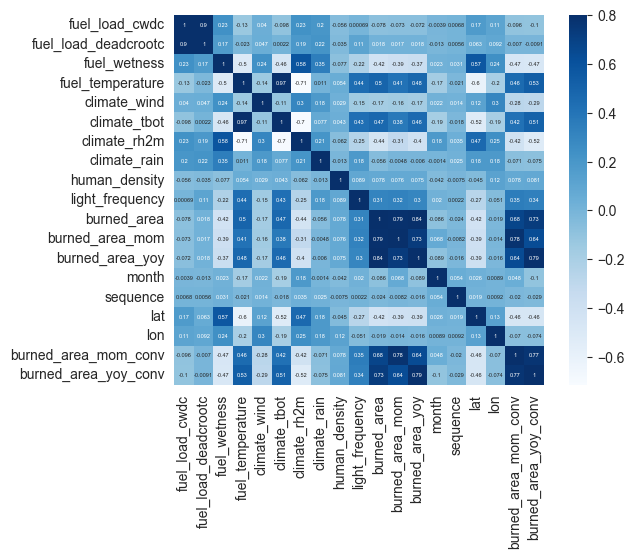

In [9]:
sns.heatmap(subset.corr(), vmax=.8, square=True, annot=True, annot_kws={"size":4}, cmap="Blues")

### Save the data to local disk

In [10]:
subset.to_csv("modeling_cnn_data.csv", index = None)